In [1]:
import srtm
from pyproj import Transformer

def quick_test():

    geo_data = srtm.get_data()
    transformer = Transformer.from_crs("EPSG:32634", "EPSG:4326", always_xy=True)

    # Dane wejściowe: Współrzędne Rynku w Krakowie 
    test_x_metry = 424000  
    test_y_metry = 5546000 

    print(f"1. Wejście (Metry): X={test_x_metry}, Y={test_y_metry}")

    lon, lat = transformer.transform(test_x_metry, test_y_metry)
    print(f"2. Wynik konwersji (GPS): Lat={lat:.4f}, Lon={lon:.4f}")

    elev = geo_data.get_elevation(lat, lon)
    print(f"3. Wysokość z SRTM: {elev}")

if __name__ == "__main__":
    quick_test()

1. Wejście (Metry): X=424000, Y=5546000
2. Wynik konwersji (GPS): Lat=50.0614, Lon=19.9382
3. Wysokość z SRTM: 220


In [1]:
from scraper.graph_loader import GraphLoader
from scraper.grid_builder import GridBuilder

graph_loader = GraphLoader()
builder = GridBuilder()
city = "Kraków, Polska"
# graph = graph_loader.load_graph(city)

gdf_edges = builder.get_city_roads(city)
residential_counter = 0
unresidential_counter = 0
for _, row in gdf_edges.iterrows():
    if row["is_residential"]:
        residential_counter += 1
    else:
        unresidential_counter += 1
print(f"Residential roads: {residential_counter}")
print(f"Unresidential roads: {unresidential_counter}")

Roads with 'width' attribute: 65231
Roads without 'width' attribute: 93208
Residential roads: 97167
Unresidential roads: 61272


In [1]:
from shapely.geometry import LineString
import osmnx as ox
from scraper.rasterizer import Rasterizer
import matplotlib.pyplot as plt
from scraper.graph_loader import GraphLoader
from scraper.grid_builder import GridBuilder
from scraper.geometry_processor import GeometryProcessor

graph_loader = GraphLoader()
builder = GridBuilder()
geometry_porcessor = GeometryProcessor()
city = "Lublin"
# graph = graph_loader.load_graph(city)
maks_len = 0
graph = graph_loader.load_graph(city)

for u, v, k, data in list(graph.edges(data=True, keys=True)):
    linestring = LineString([[graph.nodes[u]["x"], graph.nodes[u]["y"]], [graph.nodes[v]["x"], graph.nodes[v]["y"]]])
    data["geometry"] = linestring

G_projected = ox.project_graph(graph)

Zaktualizowano 'turning_radius' dla 60475 krawędzi.
Roads with 'width' attribute: 27581
Roads without 'width' attribute: 43099
17862 14007


c:\Users\Konrad\OneDrive\Pulpit\Studia\Semestr5\StudioProjektowe\CRoadA\venv\Lib\site-packages\rasterio\features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 32114 will not be rasterized.
  warnings.warn(
c:\Users\Konrad\OneDrive\Pulpit\Studia\Semestr5\StudioProjektowe\CRoadA\venv\Lib\site-packages\rasterio\features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 32115 will not be rasterized.
  warnings.warn(
c:\Users\Konrad\OneDrive\Pulpit\Studia\Semestr5\StudioProjektowe\CRoadA\venv\Lib\site-packages\rasterio\features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 32116 will not be rasterized.
  warnings.warn(
c:\Users\Konrad\OneDrive\Pulpit\Studia\Semestr5\StudioProjektowe\CRoadA\venv\Lib\site-packages\rasterio\features.py:336: ShapeSkipWarning: Invalid or empty shape {'type': 'Polygon', 'coordinates': ()} at index 32117 will not be r

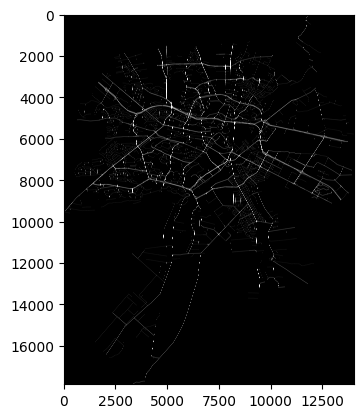

In [2]:
city = "Stawowa"
# G_projected = builder.loader.get_graph_for_street(G_projected, city)

G_projected = builder.add_radius_for_edges(G_projected, 10.0)
for u, v, k, data in G_projected.edges(data=True, keys=True):
    if data.get("name") == city and data.get("turning_radius") < 30:
        print(f"Węzeł 1: {u}, węzeł 2: {v}, data: {data}")
G_projected = builder.unify_radius_on_graph(G_projected)



G_final = ox.project_graph(G_projected, to_crs="EPSG:4326")

edges = builder.loader.get_edges_measurements(G_final, residential_max_radius=30.0)
""" for data in edges:
    if data["name"] == "Tulipanów":
        print(data) """

rasterizer = Rasterizer()
gdf_edges = builder.loader.convert_to_gdf(edges)

gdf_edges["geometry"] = gdf_edges.apply(lambda row: builder.geometry_processor.get_edge_polygon(row), axis=1)

grid = rasterizer.get_rasterize_roads(gdf_edges, is_residential=False)
plt.imshow(grid, cmap="gray")

                 display_name  osm_type  osm_id
0  Lublin Voivodeship, Poland  relation  130919


<Axes: >

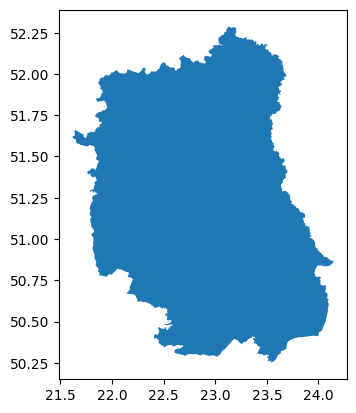

In [1]:
import osmnx as ox

gdf = ox.geocode_to_gdf("Lublin")
print(gdf[['display_name', 'osm_type', 'osm_id']])
gdf.plot()